In [1]:
using Pkg
Pkg.activate("C:/Users/ibzja/Documents/UPF_2022_2026/4t/2n_trimestre/Practiques_tutelades/CellBasedModels.jl")
using CellBasedModels 
using GeometryBasics
using Distributions
using GLMakie
Makie.inline!(true)

  Activating project at `C:\Users\ibzja\Documents\UPF_2022_2026\4t\2n_trimestre\Practiques_tutelades\CellBasedModels.jl`


true

In [2]:
using CSV, DataFrames, Statistics

In [3]:
rods2DChemotaxis = ABM(2,
    agent = Dict(
        :vx => Float64,
        :vy => Float64,
        :v => Float64,  #Swimming speed
        :theta => Float64,
        :d => Float64,
        :l => Float64,
        :m => Float64,
        :fx => Float64,
        :fy => Float64,
        :W => Float64,
        :pressure => Float64,
        :active => Bool,
        :isSource => Bool, 
        :S => Float64,

        :methyl => Float64, #Receptor methylation
        :Yp => Float64, #CheYP levels, probability of tumblingç
        :G => Float64,
        :λ => Float64,
        :P => Float64,
        :M => Float64,
        :F => Float64,
        :A => Float64,
        :M => Float64
        
    ),

    model = Dict(

        :Dr_run => Float64,

        :ε0 => Float64, #Energy parameters
        :ε1 => Float64,
        :ε2 => Float64,
        :ε3 => Float64,
        :K => Float64,
        :Nrec => Float64, #Cooperativity
        :Ki => Float64, #Dissociation constants
        :Ka => Float64,
        :τm => Float64, #Methylation adaptation timescale
        :α => Float64,      #Total Yp pool
        :ωFrec => Float64,     #Basal switching frequency
        :Ky => Float64,         #CheA - CheY phosphorylation rate
        :Z => Float64,          #CheZ concentration
        :Kz => Float64,         #CheZ mediated dephosphorylation rate
        :Yy => Float64,         #Basa Yp leak

        :DMedium => Float64
    ),

    medium = Dict(
        :mm => Float64
    ),

    agentODE = quote

        F = ε0 + ε1 * methyl + Nrec * log((1 + mm / Ki) / (1 + mm / Ka)) #Equació del paper per definir activitat del receptor
        F0 = log(((Ky * (α - K)) / (K * (Kz * Z + Yy))) - 1)        #Energia lliure en estat adaptat

        mx = (ε0 + Nrec * log((1 + mm / Ki) / (1 + mm / Ka)) - F0) / (- ε1)

        A = 1 / (1 + exp(F))    

        Yp = (Ky * A * α) / ((Ky * A) + (Kz * Z) + Yy)

        G = ε2 / 4 - (ε3 / 2) / (1 + (K / Yp))      #CheYp segons activitat receptor

        dt(x) = active * vx  #Change position acording to constant speed afected by forces
        dt(y) = active * vy  
        dt(methyl) = -(1 / τm) * (methyl - mx)        #Methylation
        
    end,

    agentRule = quote

        M = mm

        # if isSource  for difusive movement - random walk, not yet
        #     σ = sqrt(2 * DSource / dt)

        #     vx = σ * randn()
        #     vy = σ * randn()
        #     ω = 0.0

        #     mm += S
        # end

        if isSource
            mm += S
        end

        if active
            λrt = ωFrec*exp(-G)*dt 
            P_rt = 1 - exp(-λrt * dt)
            P = rand() 
                                    #Si rate alta = mes probabilitat de canvi. Per tant, si random number mes petit =  canvi. 
            if P < P_rt             #Si rate alta = mes probabilitat de canvi. Per tant, si random number mes petit =  canvi. 
                active = false
                vx = 0
                vy = 0
                theta = rand(Uniform(0, 2π))            #Tumble = random reorientation
            else     #Si rate baixa 
                active = true
                vx = v * cos(theta)
                vy = v * sin(theta)
                theta += sqrt(2 * Dr_run * dt) * randn()        #Keep running, reorientation according to rotational difusion
            end

        else
            λtr = ωFrec*exp(G) *dt
            P_tr = 1 - exp(-λtr * dt)
            P = rand()
    
            if P < P_tr
                active = true
                vx = v * cos(theta)
                vy = v * sin(theta)
                theta += sqrt(2 * Dr_run * dt) * randn()
            else
                active = false
                vx = 0
                vy = 0
                theta = rand(Uniform(0, 2π))
            end
            
        end

        # if x < simBox[1,1]
        #     x = simBox[1,1]
        #     theta = pi - theta      
        # elseif x > simBox[1,2]
        #     x = simBox[1,2]
        #     theta = pi - theta
        # end
        # if y < simBox[2,1]
        #     y = simBox[2,1]
        #     theta = -theta
        # elseif y > simBox[2,2]
        #     y = simBox[2,2]
        #     theta = -theta
        # end

    end,

    mediumODE = quote
        if @mediumInside()
            dt(mm) = DMedium *(@∂2(1, mm)+ @∂2(2, mm))
        end
    end,

    neighborsAlg = CBMNeighbors.CellLinked(cellEdge = 4)
)

PARAMETERS
	x (Float64 agent)
	y (Float64 agent)
	xₘ (Float64 medium)
	yₘ (Float64 medium)
	F (Float64 agent)
	active (Bool agent)
	methyl (Float64 agent)
	l (Float64 agent)
	S (Float64 agent)
	M (Float64 agent)
	d (Float64 agent)
	λ (Float64 agent)
	v (Float64 agent)
	isSource (Bool agent)
	A (Float64 agent)
	fx (Float64 agent)
	vx (Float64 agent)
	fy (Float64 agent)
	m (Float64 agent)
	Yp (Float64 agent)
	P (Float64 agent)
	pressure (Float64 agent)
	vy (Float64 agent)
	W (Float64 agent)
	G (Float64 agent)
	theta (Float64 agent)
	ε1 (Float64 model)
	α (Float64 model)
	Z (Float64 model)
	Dr_run (Float64 model)
	Ka (Float64 model)
	ε3 (Float64 model)
	ε0 (Float64 model)
	DMedium (Float64 model)
	Ky (Float64 model)
	Kz (Float64 model)
	K (Float64 model)
	ε2 (Float64 model)
	Nrec (Float64 model)
	τm (Float64 model)
	Yy (Float64 model)
	Ki (Float64 model)
	ωFrec (Float64 model)
	mm (Float64 medium)


UPDATE RULES
mediumODE
 if @mediumInside()
    dt__mm = DMedium * (@∂2(1, mm) + @∂2(2, mm)

In [4]:
com = Community(
    rods2DChemotaxis,
    N=20,
    dt=0.1,
    simBox = [-20.0 20.0; -20.0 20.0],
    NMedium = [200, 200]
)

m = 1/100
g = 1/10000
d = 1

com.Dr_run = 0.062

# com.v = 20.0
# com.v = 10.0
# com.v = 5.0
com.v = 0.5

com.ωFrec = 1.3
com.Ki = 0.0182
com.Ka = 3.0
com.Nrec = 6.0
com.ε0   = 6.0
com.ε1   = -1.0
com.ε2   = 80
com.ε3   = 80

# com.τm = 5.0
# com.τm = 10.0
com.τm = 30.0

com.α   = 6.0

# com.DMedium = 0.1
com.DMedium = 5

com.K = 2.0 

com.Ky = 100.0
com.Kz = 10.0
com.Z = 5.0
com.Yy = 0.1

com.m = 1.        
com.d = 1.        
com.l = 3;

com.x = rand(Uniform(com.simBox[1,:]...),com.N)
com.y = rand(Uniform(com.simBox[2,:]...),com.N)
com.theta = rand(Uniform(0,2π),com.N)

com.methyl .= 0.0
com.Yp .= com.K

src = 1

com.x[src] = 0
com.y[src] = 0

com.isSource .= false
com.isSource[src] = true

com.active .= true 
com.active[src] = false   

com.S .= 0.0
com.S[src] = 2.0

2.0

In [ ]:
outfile = "source_4.csv"
data = DataFrame(
    step = Int[],
    id = Int[],
    x = Float64[],
    y = Float64[],
    active = Bool[],
    isSource = Bool[],
    M = Float64[]
)



steps = 100
saveEach = 10
loadToPlatform!(com, preallocateAgents=20)       #Preallocate agents = number of agents in community


for step in 1:steps 
    step!(com)
    if step % saveEach == 0
        for i in 1:com.N
            push!(data, (
                step, 
                i,
                com.x[i],
                com.y[i],
                com.active[i],
                com.isSource[i],
                com.M[i]
                
            ))
        end
    end
end

CSV.write(outfile, data)

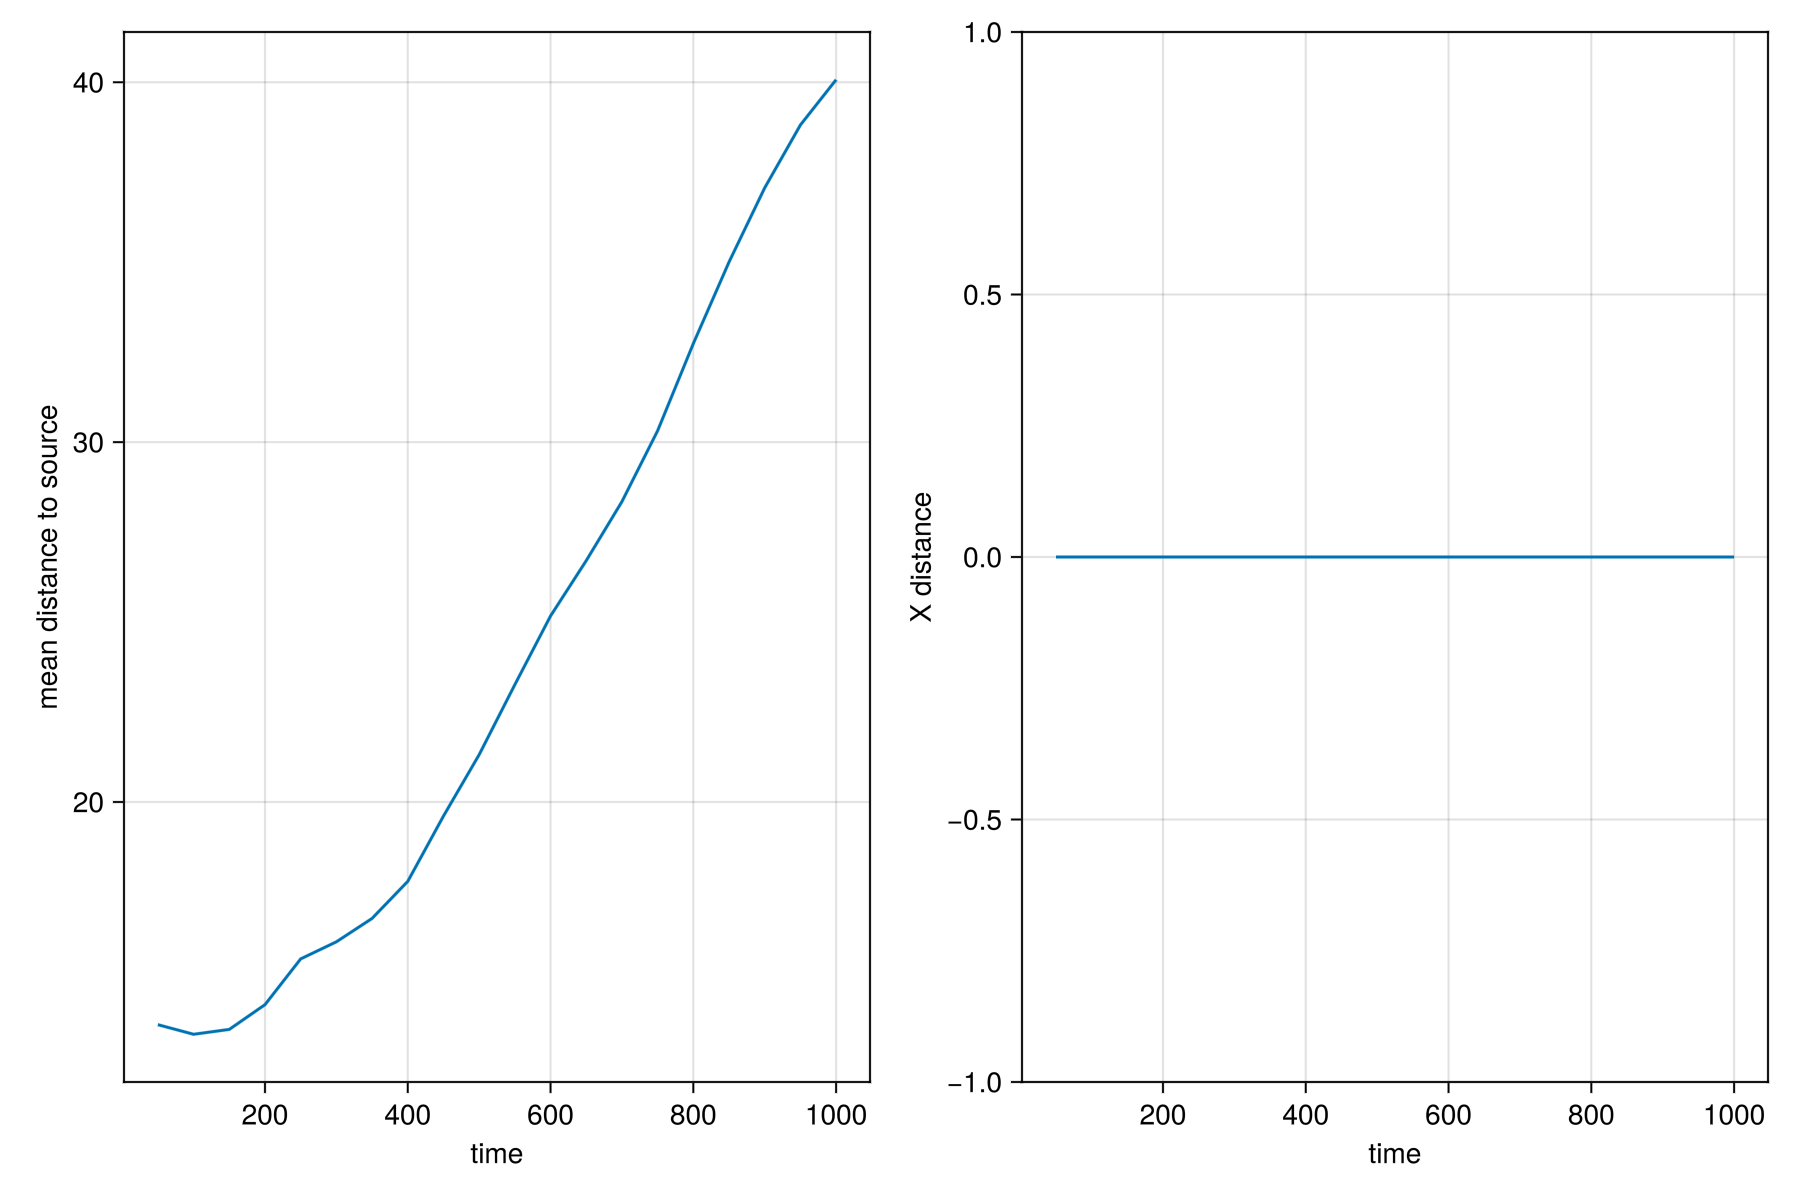

GLMakie.Screen(...)

In [6]:
# Plot mean distance to source
src_id = findfirst(data[!, :isSource][1])

mean_dist = Float64[]

for df_step in groupby(data, :step)

    # Source position at this step
    src = df_step[df_step.isSource .== true, :]
    isempty(src) && continue   # safety

    xs = src.x[1]
    ys = src.y[1]

    # Non-source bacteria
    others = df_step[df_step.isSource .== false, :]

    dists = sqrt.((others.x .- xs).^2 .+ (others.y .- ys).^2)

    push!(mean_dist, mean(dists))
end

fig = Figure(size=(900, 600))

ax1 = Axis(fig[1,1], xlabel="time", ylabel="mean distance to source")
lines!(ax1, unique(data[!, :step]), mean_dist)
ax2 = Axis(fig[1,2], xlabel = "time", ylabel = "X distance")
lines!(ax2, data[:, :step], data[:, :M])

display(fig)